# 1H Strategy Tester

Notebook untuk menguji strategi trading 1 jam (1H). Isi path data OHLCV, pilih strategi, lalu jalankan sel untuk menghitung metrik performa, statistik trade, dan visualisasi ekuitas.

In [1]:
from __future__ import annotations

import contextlib
import sys
from pathlib import Path


def locate_project_root() -> tuple[Path, Path]:
    current = Path.cwd().resolve()
    for candidate in (current, *current.parents):
        src_dir = candidate / "src"
        if src_dir.exists():
            return candidate, src_dir
    raise RuntimeError("Tidak dapat menemukan folder 'src'.")


PROJECT_ROOT, SRC_PATH = locate_project_root()

for path in (PROJECT_ROOT, SRC_PATH):
    path_str = str(path)
    if path_str not in sys.path:
        sys.path.insert(0, path_str)

try:
    import sitecustomize  # noqa: F401
except Exception:
    with contextlib.suppress(Exception):
        import matplotlib

        rc_params = getattr(matplotlib, "rcParams", None)
        if rc_params is not None and not hasattr(rc_params, "_get"):
            rc_params._get = rc_params.get  # type: ignore[attr-defined]

print(f"Project root: {PROJECT_ROOT}")
print(f"SRC path   : {SRC_PATH}")

Project root: C:\Users\jefri\backtest-indicator
SRC path   : C:\Users\jefri\backtest-indicator\src


In [2]:
import matplotlib.pyplot as plt
import pandas as pd

from backtest import performance_metrics, run_backtest
from data_loader import load_ohlcv_csv
from properties import StrategyProperties
from qflib_metrics import qflib_metrics_from_returns
from trade_analysis import failed_entries, generate_trade_log, summarise_trades
from strategy_registry import available_strategies, get_strategy


## Konfigurasi Awal

Ubah path CSV dan parameter strategi sesuai kebutuhan Anda. CSV harus berisi kolom `time` berformat UNIX timestamp serta kolom harga standar (`open`, `high`, `low`, `close`).

In [3]:
CSV_PATH = PROJECT_ROOT / "data" / "sample_1h_data.csv"  # Ganti dengan file Anda
STRATEGY_NAME = "ema112"  # Pilih dari available_strategies()
PROPERTIES = StrategyProperties(
    symbol="BTCUSDT",
    timeframe="1H",
    initial_capital=10_000.0,
    trading_cost_bps=0.0,
)

print(f"CSV path      : {CSV_PATH}")
print(f"Strategy name : {STRATEGY_NAME}")
print(f"Initial capital: {PROPERTIES.initial_capital:,.2f}")


CSV path      : C:\Users\jefri\backtest-indicator\data\sample_1h_data.csv
Strategy name : ema112
Initial capital: 10,000.00


In [4]:
if not CSV_PATH.exists():
    raise FileNotFoundError(
        f"File data tidak ditemukan: {CSV_PATH}. Perbarui variabel CSV_PATH sebelum melanjutkan."
    )

raw_data = load_ohlcv_csv(str(CSV_PATH))
raw_data.tail()


,open,high,low,close
time,,,,
2023-01-30 19:00:00+00:00,22455.760115,22464.804426,22453.393249,22450.016391
2023-01-30 20:00:00+00:00,22406.363598,22413.195506,22392.155362,22406.264213
2023-01-30 21:00:00+00:00,22423.887282,22446.697893,22390.473622,22432.290957
2023-01-30 22:00:00+00:00,22361.475546,22373.046736,22307.897981,22381.621570
2023-01-30 23:00:00+00:00,22367.410251,22426.070250,22322.025258,22376.473556


Strategi tersedia: atr_filter, ema112, ema45, ema50, ema_vs_price, macd, oversold


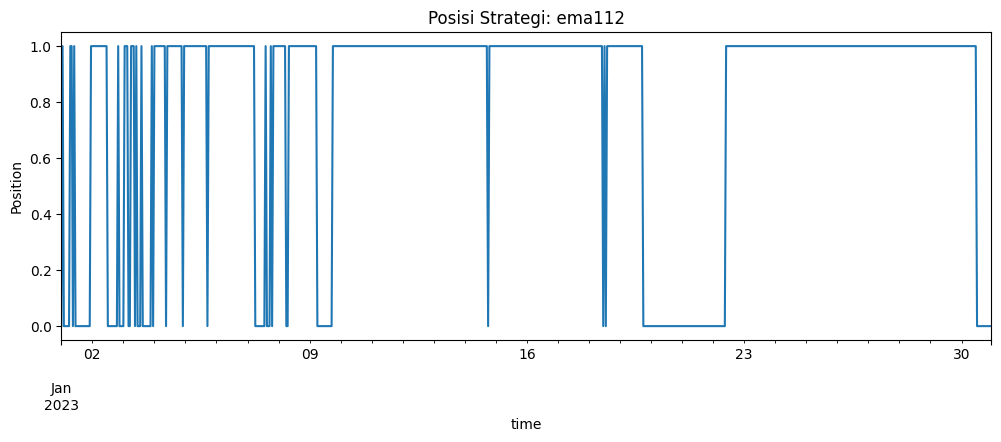

In [5]:
print("Strategi tersedia:", ", ".join(available_strategies()))
strategy_fn = get_strategy(STRATEGY_NAME)
positions = strategy_fn(raw_data)

fig, ax = plt.subplots(figsize=(12, 4))
positions.plot(ax=ax)
ax.set_title(f"Posisi Strategi: {STRATEGY_NAME}")
ax.set_ylabel("Position")
plt.show()


In [6]:
backtest_kwargs = PROPERTIES.to_kwargs()
result = run_backtest(raw_data, positions, **backtest_kwargs)
result[["close", "position", "strategy_ret", "equity_curve"]].head()


,close,position,strategy_ret,equity_curve
time,,,,
2023-01-01 00:00:00+00:00,20034.028145,0.0,0.000000,10000.000000
2023-01-01 01:00:00+00:00,20108.425611,1.0,0.000000,10000.000000
2023-01-01 02:00:00+00:00,19997.957481,0.0,-0.005494,9945.063759
2023-01-01 03:00:00+00:00,19954.852657,0.0,-0.000000,9945.063759
2023-01-01 04:00:00+00:00,19938.669364,0.0,-0.000000,9945.063759


In [8]:
perf_metrics = performance_metrics(result["equity_curve"])
qflib_stats = qflib_metrics_from_returns(result["strategy_ret"])

print("Performance Metrics:")
display(pd.Series(perf_metrics, name="Backtest"))

print("QF-Lib Metrics:")
display(pd.Series(qflib_stats, name="QF-Lib"))


Performance Metrics:


total_return               0.068602
annualized_return          0.023528
annualized_volatility      0.035929
sharpe_ratio               0.654844
max_drawdown              -0.045459
max_drawdown_duration    379.000000
Name: Backtest, dtype: float64

QF-Lib Metrics:


total_return              0.068602
cagr                      0.023495
sharpe_ratio              0.664350
annualised_vol            0.035929
max_drawdown             -0.045459
avg_drawdown_duration    35.315789
Name: QF-Lib, dtype: float64

In [10]:
trade_log = generate_trade_log(result, initial_capital=PROPERTIES.initial_capital)
trade_summary = summarise_trades(trade_log)

print("Ringkasan Trade:")
display(pd.Series(trade_summary.__dict__, name="Summary"))

print("Log Trade (5 baris terakhir):")
display(trade_log.tail())


Ringkasan Trade:


AttributeError: 'TradeSummary' object has no attribute '__dict__'

In [ ]:
failed_trades = failed_entries(trade_log)
print(f"Total trade gagal/threshold: {len(failed_trades)}")
display(failed_trades.head())


In [ ]:
fig, (ax_eq, ax_dd) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
result["equity_curve"].plot(ax=ax_eq, color="tab:blue")
ax_eq.set_title("Equity Curve")
ax_eq.set_ylabel("Equity")

result["drawdown"].plot(ax=ax_dd, color="tab:red")
ax_dd.set_title("Drawdown")
ax_dd.set_ylabel("Drawdown")
ax_dd.set_xlabel("Date")

plt.tight_layout()
plt.show()
